# Electricity Price Forecasting with Deep Neural Networks

In [1]:
# import important libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import data
df_w = pd.read_csv('./data/weather_features.csv')
df_w.head(3)

dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_icon  
0         800        clear        sky is clear          01n  
1         800        clear        sky is clear          01n  
2         800        clear        sky is clear          01n

In [3]:
# import data
df_e = pd.read_csv('./data/energy_dataset.csv')
df_e.head(3)

time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   

   ...  generation waste  generation wind offshore  generation wind onshore  \
0  ...             196.0                       0.0                   6378.0   
1  ...             195.0                       0.0                   5890.0   
2  ...             196.0                       0.0                   5461.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                      17.0                                NaN   
1                      16.0                                NaN   
2                       8.0                                NaN   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                           6436.0              26118.0            25385.0   
1                           5856.0              24934.0            24382.0   
2                           5454.0              23515.0            22734.0   

   price day ahead  price actual  
0            50.10         65.41  
1            48.10         64.92  
2            47.33         64.48  

[3 rows x 29 columns]

We will drop all the columns that are constituted by zeroes and NaNs, as they are unusable. We will also remove the columns which will not be used at all in our analysis and which contain day-ahead forecasts for the total load, the solar energy and the wind energy.

In [4]:
# Drop unusable columns
df_e = df_e.drop(['generation fossil coal-derived gas','generation fossil oil shale', 
                            'generation fossil peat', 'generation geothermal', 
                            'generation hydro pumped storage aggregated', 'generation marine', 
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'], 
                            axis=1)

In [5]:
df_e.head(3)

time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   

   generation fossil brown coal/lignite  generation fossil gas  \
0                                 329.0                 4844.0   
1                                 328.0                 5196.0   
2                                 323.0                 4857.0   

   generation fossil hard coal  generation fossil oil  \
0                       4821.0                  162.0   
1                       4755.0                  158.0   
2                       4581.0                  157.0   

   generation hydro pumped storage consumption  \
0                                        863.0   
1                                        920.0   
2                                       1164.0   

   generation hydro run-of-river and poundage  \
0                                      1051.0   
1                                      1009.0   
2                                       973.0   

   generation hydro water reservoir  generation nuclear  generation other  \
0                            1899.0              7096.0              43.0   
1                            1658.0              7096.0              43.0   
2                            1371.0              7099.0              43.0   

   generation other renewable  generation solar  generation waste  \
0                        73.0              49.0             196.0   
1                        71.0              50.0             195.0   
2                        73.0              50.0             196.0   

   generation wind onshore  total load actual  price day ahead  price actual  
0                   6378.0            25385.0            50.10         65.41  
1                   5890.0            24382.0            48.10         64.92  
2                   5461.0            22734.0            47.33         64.48

In [7]:
df_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
time                                           35064 non-null object
generation biomass                             35045 non-null float64
generation fossil brown coal/lignite           35046 non-null float64
generation fossil gas                          35046 non-null float64
generation fossil hard coal                    35046 non-null float64
generation fossil oil                          35045 non-null float64
generation hydro pumped storage consumption    35045 non-null float64
generation hydro run-of-river and poundage     35045 non-null float64
generation hydro water reservoir               35046 non-null float64
generation nuclear                             35047 non-null float64
generation other                               35046 non-null float64
generation other renewable                     35046 non-null float64
generation solar                               35046

In [12]:
print('There are {} missing values or NaNs in df_energy.'.format(df_e.isnull().values.sum()))

temp_energy = df_e.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'.format(temp_energy))

There are 292 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


In [10]:
df_e.describe()

generation biomass  generation fossil brown coal/lignite  \
count        35045.000000                          35046.000000   
mean           383.513540                            448.059208   
std             85.353943                            354.568590   
min              0.000000                              0.000000   
25%            333.000000                              0.000000   
50%            367.000000                            509.000000   
75%            433.000000                            757.000000   
max            592.000000                            999.000000   

       generation fossil gas  generation fossil hard coal  \
count           35046.000000                 35046.000000   
mean             5622.737488                  4256.065742   
std              2201.830478                  1961.601013   
min                 0.000000                     0.000000   
25%              4126.000000                  2527.000000   
50%              4969.000000                  4474.000000   
75%              6429.000000                  5838.750000   
max             20034.000000                  8359.000000   

       generation fossil oil  generation hydro pumped storage consumption  \
count           35045.000000                                 35045.000000   
mean              298.319789                                   475.577343   
std                52.520673                                   792.406614   
min                 0.000000                                     0.000000   
25%               263.000000                                     0.000000   
50%               300.000000                                    68.000000   
75%               330.000000                                   616.000000   
max               449.000000                                  4523.000000   

       generation hydro run-of-river and poundage  \
count                                35045.000000   
mean                                   972.116108   
std                                    400.777536   
min                                      0.000000   
25%                                    637.000000   
50%                                    906.000000   
75%                                   1250.000000   
max                                   2000.000000   

       generation hydro water reservoir  generation nuclear  generation other  \
count                      35046.000000        35047.000000      35046.000000   
mean                        2605.114735         6263.907039         60.228585   
std                         1835.199745          839.667958         20.238381   
min                            0.000000            0.000000          0.000000   
25%                         1077.250000         5760.000000         53.000000   
50%                         2164.000000         6566.000000         57.000000   
75%                         3757.000000         7025.000000         80.000000   
max                         9728.000000         7117.000000        106.000000   

       generation other renewable  generation solar  generation waste  \
count                35046.000000      35046.000000      35045.000000   
mean                    85.639702       1432.665925        269.452133   
std                     14.077554       1680.119887         50.195536   
min                      0.000000          0.000000          0.000000   
25%                     73.000000         71.000000        240.000000   
50%                     88.000000        616.000000        279.000000   
75%                     97.000000       2578.000000        310.000000   
max                    119.000000       5792.000000        357.000000   

       generation wind onshore  total load actual  price day ahead  \
count             35046.000000       35028.000000     35064.000000   
mean               5464.479769       28696.939905        49.874341   
std                3213.691587        4574.987950        14.618900   
min          

In [11]:
# Convert time to datetime
df_e['time'] = pd.to_datetime(df_e['time'], utc=True, infer_datetime_format=True)
df_e = df_e.set_index('time')

In [13]:
def plot_s(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

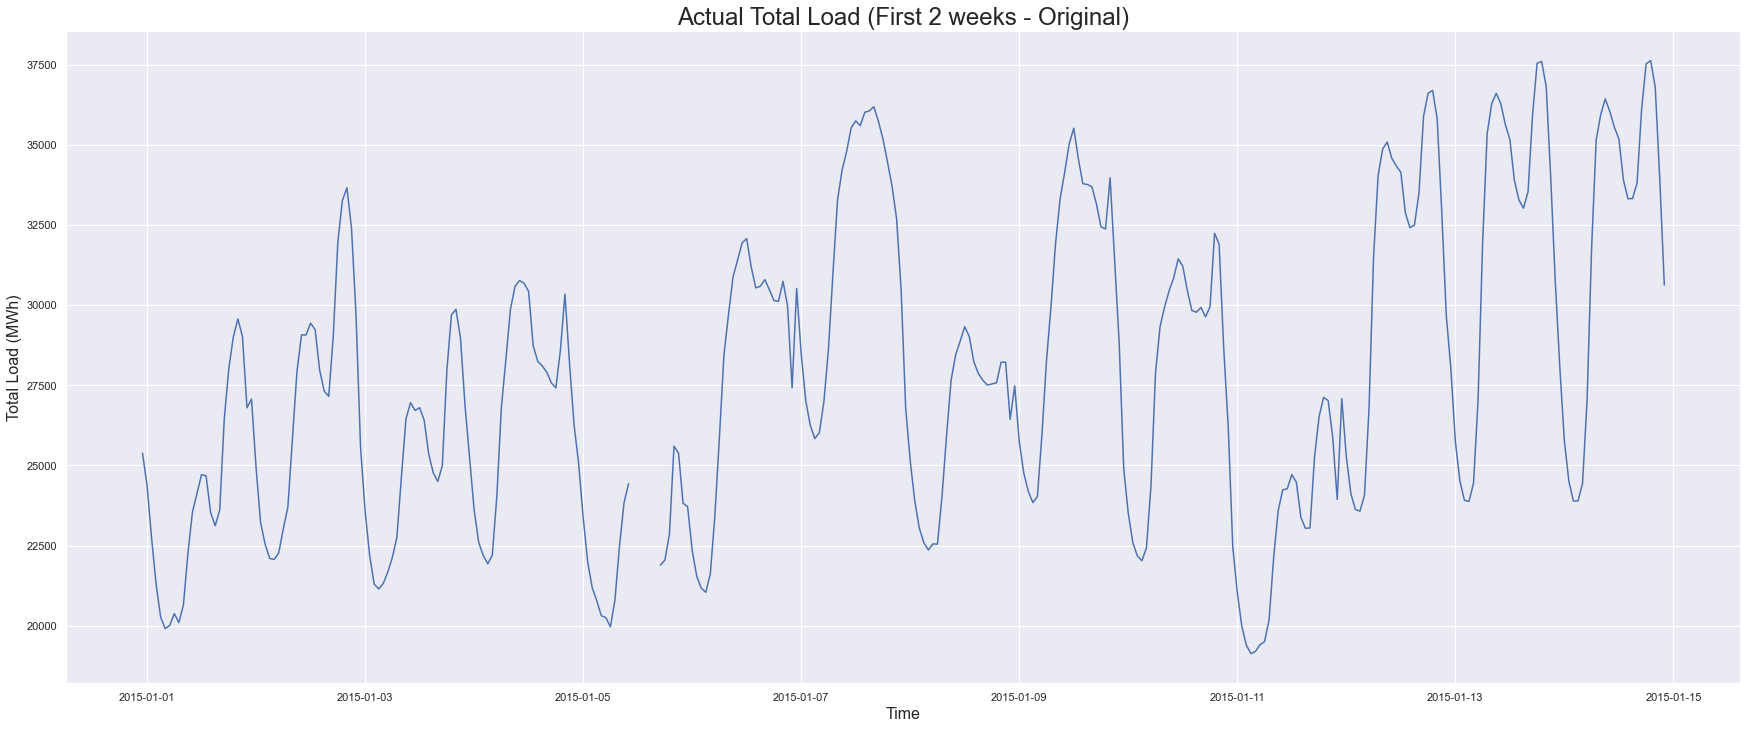

In [16]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
ax = plot_s(df=df_e, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Original)', end=24*7*2)
plt.show()

In [2]:
# import data
df_us = pd.read_csv('./data/US_WeatherEvents_2016-2019.csv')
df_us.head(3)

EventId  Type Severity       StartTime(UTC)         EndTime(UTC)  \
0     W-1  Snow    Light  2016-01-06 23:14:00  2016-01-07 00:34:00   
1     W-2  Snow    Light  2016-01-07 04:14:00  2016-01-07 04:54:00   
2     W-3  Snow    Light  2016-01-07 05:54:00  2016-01-07 15:34:00   

      TimeZone AirportCode  LocationLat  LocationLng      City    County  \
0  US/Mountain        K04V      38.0972    -106.1689  Saguache  Saguache   
1  US/Mountain        K04V      38.0972    -106.1689  Saguache  Saguache   
2  US/Mountain        K04V      38.0972    -106.1689  Saguache  Saguache   

  State  ZipCode  
0    CO  81149.0  
1    CO  81149.0  
2    CO  81149.0

In [5]:
df_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5059833 entries, 0 to 5059832
Data columns (total 13 columns):
EventId           object
Type              object
Severity          object
StartTime(UTC)    object
EndTime(UTC)      object
TimeZone          object
AirportCode       object
LocationLat       float64
LocationLng       float64
City              object
County            object
State             object
ZipCode           float64
dtypes: float64(3), object(10)
memory usage: 501.8+ MB


In [7]:
df_us['Type'].value_counts()

Rain             3067581
Fog              1068653
Snow              679472
Cold              141626
Precipitation      67299
Storm              32688
Hail                2514
Name: Type, dtype: int64

In [9]:
df_us['Severity'].value_counts()

Light       3124333
Severe       884355
Moderate     842926
Heavy        138406
UNK           67299
Other          2514
Name: Severity, dtype: int64

In [12]:
df_us = df_us[(df_us['Severity'] != 'UNK') & (df_us['Severity'] != 'Other')]

df_us.head()

EventId  Type Severity       StartTime(UTC)         EndTime(UTC)  \
0     W-1  Snow    Light  2016-01-06 23:14:00  2016-01-07 00:34:00   
1     W-2  Snow    Light  2016-01-07 04:14:00  2016-01-07 04:54:00   
2     W-3  Snow    Light  2016-01-07 05:54:00  2016-01-07 15:34:00   
3     W-4  Snow    Light  2016-01-08 05:34:00  2016-01-08 05:54:00   
4     W-5  Snow    Light  2016-01-08 13:54:00  2016-01-08 15:54:00   

      TimeZone AirportCode  LocationLat  LocationLng      City    County  \
0  US/Mountain        K04V      38.0972    -106.1689  Saguache  Saguache   
1  US/Mountain        K04V      38.0972    -106.1689  Saguache  Saguache   
2  US/Mountain        K04V      38.0972    -106.1689  Saguache  Saguache   
3  US/Mountain        K04V      38.0972    -106.1689  Saguache  Saguache   
4  US/Mountain        K04V      38.0972    -106.1689  Saguache  Saguache   

  State  ZipCode  
0    CO  81149.0  
1    CO  81149.0  
2    CO  81149.0  
3    CO  81149.0  
4    CO  81149.0

In [14]:
df_types = df_us[['AirportCode','Type']]

df_types.head()

AirportCode  Type
0        K04V  Snow
1        K04V  Snow
2        K04V  Snow
3        K04V  Snow
4        K04V  Snow

In [15]:
types = pd.get_dummies(df_types['Type']) 

types['AirportCode'] = df_types['AirportCode']

types = types.groupby('AirportCode').sum().reset_index()

types.head()

AirportCode   Cold    Fog    Rain    Snow  Storm
0        K01M   18.0  769.0  1849.0    53.0    0.0
1        K04V   18.0   61.0  1063.0   535.0   41.0
2        K04W   87.0  411.0  1459.0   784.0    1.0
3        K06D  591.0  632.0   768.0  1685.0   74.0
4        K08D  737.0  984.0   592.0  1090.0   18.0

### Analyze, identify patterns, and explore the data.
### k-Means Clustering

In [16]:
codes = types[['AirportCode']]
types.drop('AirportCode', axis=1, inplace=True)

In [20]:
import folium # plotting library
from folium import plugins

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [19]:
!pip install folium

     |████████████████████████████████| 93 kB 4.5 MB/s  eta 0:00:01
You should consider upgrading via the '/Users/marigaldina/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [21]:
#Elbow method 
distortions = [] 
K = range(1,20)
for k in K: 
    kmean = KMeans(n_clusters=k, random_state=0, n_init = 50, max_iter = 500)
    kmean.fit(types) 
    distortions.append(kmean.inertia_)

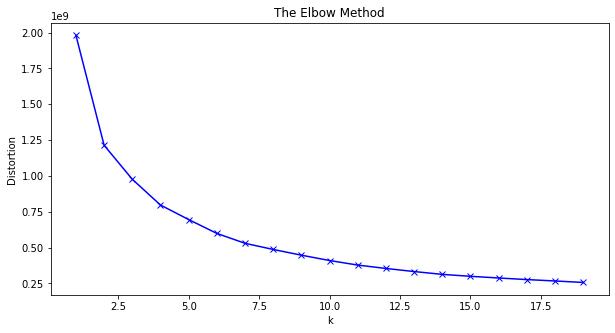

In [22]:
plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

In [25]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(types)

codes['cluster'] = kmeans.labels_
codes.head()

/Users/marigaldina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


AirportCode  cluster
0        K01M        2
1        K04V        1
2        K04W        3
3        K06D        3
4        K08D        3

In [27]:
pca = PCA().fit(types)
pca_types = pca.transform(types)
print("Variance explained by each component (%): ")
for i in range(len(pca.explained_variance_ratio_)):
      print("\n",i+1,":", pca.explained_variance_ratio_[i]*100)
print("Total sum (%): ",sum(pca.explained_variance_ratio_)*100)
print("Explained variance of the first two components (%): ",sum(pca.explained_variance_ratio_[0:1])*100)

Variance explained by each component (%): 

 1 : 63.65401032509336

 2 : 21.33030029759995

 3 : 12.907174661299523

 4 : 1.454698126243973

 5 : 0.6538165897631995
Total sum (%):  100.0
Explained variance of the first two components (%):  63.65401032509336


Text(0.5, 1.0, 'Low dimensional visualization (PCA) - Airports')

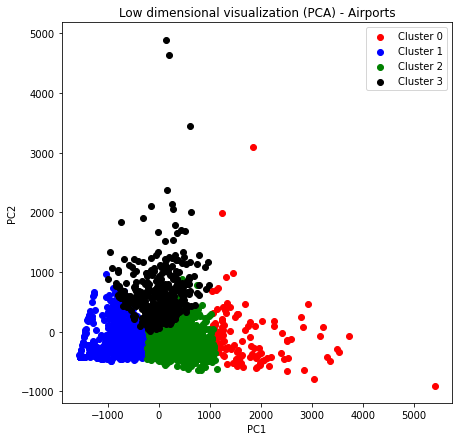

In [30]:
c0 = []
c1 = []
c2 = []
c3 = []
for i in range(len(pca_types)):
    if kmeans.labels_[i] == 0:
        c0.append(pca_types[i])
    if kmeans.labels_[i] == 1:
        c1.append(pca_types[i])
    if kmeans.labels_[i] == 2:
        c2.append(pca_types[i])
    if kmeans.labels_[i] == 3:
        c3.append(pca_types[i])

c0 = np.array(c0) 
c1 = np.array(c1)
c2 = np.array(c2)
c3 = np.array(c3)

plt.figure(figsize=(7,7)) 
plt.scatter(c0[:,0], c0[:,1], c='red', label='Cluster 0')
plt.scatter(c1[:,0], c1[:,1], c='blue', label='Cluster 1')
plt.scatter(c2[:,0], c2[:,1], c='green', label='Cluster 2')
plt.scatter(c3[:,0], c3[:,1], c='black', label='Cluster 3')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Low dimensional visualization (PCA) - Airports')

In [31]:
types['cluster']  = kmeans.labels_

types.head()

Cold    Fog    Rain    Snow  Storm  cluster
0   18.0  769.0  1849.0    53.0    0.0        2
1   18.0   61.0  1063.0   535.0   41.0        1
2   87.0  411.0  1459.0   784.0    1.0        3
3  591.0  632.0   768.0  1685.0   74.0        3
4  737.0  984.0   592.0  1090.0   18.0        3

In [32]:
types.groupby('cluster').mean()

Cold         Fog         Rain        Snow      Storm
cluster                                                            
0         67.254545  902.636364  3238.863636  173.545455  10.918182
1         68.142429  352.064468   665.499250  193.191904  24.232384
2         53.967452  495.374860  1892.493827  166.314254   5.453423
3        101.223881  729.246269  1445.786070  953.574627  26.032338

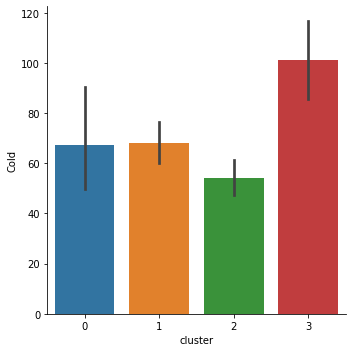

In [33]:
sns.catplot(x='cluster', y='Cold', data=types, kind='bar');


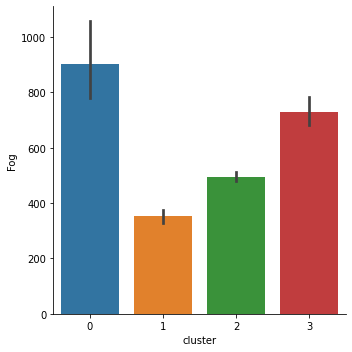

In [34]:
sns.catplot(x='cluster', y='Fog', data=types, kind='bar');

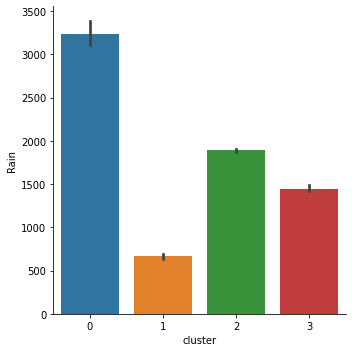

In [35]:
sns.catplot(x='cluster', y='Rain', data=types, kind='bar');

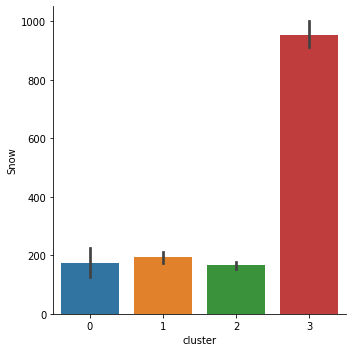

In [36]:
sns.catplot(x='cluster', y='Snow', data=types, kind='bar');

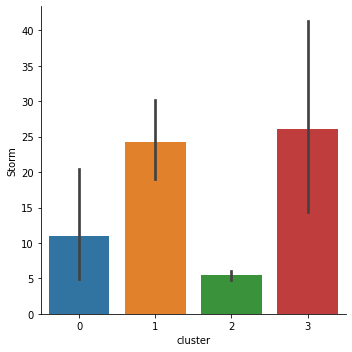

In [37]:
sns.catplot(x='cluster', y='Storm', data=types, kind='bar');

In [38]:
latitude = 38.500000
longitude = -95.665

map_USA = folium.Map(location=[latitude, longitude], zoom_start=4)

map_USA

In [40]:
airports = df_us[['AirportCode', 'LocationLat','LocationLng','City','State']]

airports.head()

AirportCode  LocationLat  LocationLng      City State
0        K04V      38.0972    -106.1689  Saguache    CO
1        K04V      38.0972    -106.1689  Saguache    CO
2        K04V      38.0972    -106.1689  Saguache    CO
3        K04V      38.0972    -106.1689  Saguache    CO
4        K04V      38.0972    -106.1689  Saguache    CO

In [41]:
number_of_occurences = pd.DataFrame(airports['AirportCode'].value_counts())
number_of_occurences.reset_index(inplace=True)
number_of_occurences.columns = ['AirportCode', 'Count']
number_of_occurences.head()

AirportCode  Count
0        K3TH   8816
1        KHYW   8588
2        KMLP   8563
3        KJXI   7753
4        KSMP   7556

In [42]:
number_of_occurences = number_of_occurences.merge(airports.drop_duplicates())

number_of_occurences = number_of_occurences.merge(codes)

number_of_occurences.head()

AirportCode  Count  LocationLat  LocationLng                     City State  \
0        K3TH   8816      47.6000    -115.3667  Thompson Falls-West End    MT   
1        KHYW   8588      33.8285     -79.1222                   Conway    SC   
2        KMLP   8563      47.4542    -115.6697                   Mullan    ID   
3        KJXI   7753      32.6990     -94.9489                   Gilmer    TX   
4        KSMP   7556      47.2765    -121.3382                 Enumclaw    WA   

   cluster  
0        3  
1        0  
2        3  
3        0  
4        3

In [43]:
occurences = folium.map.FeatureGroup()
n_mean = number_of_occurences['Count'].mean()

In [45]:
for lat, lng, number, city, state in zip(number_of_occurences['LocationLat'],
                                         number_of_occurences['LocationLng'],
                                         number_of_occurences['Count'],
                                         number_of_occurences['City'],
                                         number_of_occurences['State'],):
    occurences.add_child(
        folium.vector_layers.CircleMarker(
            [lat, lng],
            radius=number/n_mean*5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            tooltip = str(number)+','+str(city) +','+ str(state)
        )
    )

map_USA.add_child(occurences)


In [4]:
df_ca = df_us['State'] == 'CA'
df_ca = df_us[df_ca]
print("Number of weather events in CA:", df_ca.size)

Number of weather events in CA: 2623868


In [7]:
import datetime as dt
import warnings

#Aggregate and group weather data data
start = pd.DatetimeIndex(df_ca['StartTime(UTC)']);
end = pd.DatetimeIndex(df_ca['EndTime(UTC)']);
df_ca['Mean_Duration'] = (end-start).total_seconds()
df_ca['Year'] = start.year
df_ca['Month'] = start.month
grouped = df_ca.groupby(by=['Year','Month','Type','Severity'] ,as_index=False).agg({'Mean_Duration': "mean", 'EventId': "count"})
grouped['Count'] = grouped.EventId
df_caGrouped = grouped[['Year','Month','Type','Severity','Count',"Mean_Duration"]]
df_caGrouped.head(12)

/Users/marigaldina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/marigaldina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/marigaldina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

Year  Month           Type  Severity  Count  Mean_Duration
0   2016      1           Cold    Severe    179   22092.737430
1   2016      1            Fog  Moderate    887    4872.784667
2   2016      1            Fog    Severe   2170    4933.990783
3   2016      1  Precipitation       UNK    135    1651.111111
4   2016      1           Rain     Heavy    126    1879.523810
5   2016      1           Rain     Light   4428    5021.598916
6   2016      1           Rain  Moderate   1037    2777.820636
7   2016      1           Snow     Heavy     88    2449.772727
8   2016      1           Snow     Light    367    4676.239782
9   2016      1           Snow  Moderate    166    2068.554217
10  2016      1          Storm    Severe     75    3556.000000
11  2016      2           Cold    Severe    204   25397.941176

In [8]:
#Prepare weather set for machine learning
types = [{'Type': 'Cold', 'Severity': 'Severe'},{'Type': 'Fog', 'Severity': 'Moderate'},{'Type': 'Fog', 'Severity': 'Severe'},{'Type': 'Precipitation', 'Severity': 'UNK'},
                {'Type': 'Rain', 'Severity': 'Heavy'},{'Type': 'Rain', 'Severity': 'Light'},{'Type': 'Rain', 'Severity': 'Moderate'},{'Type': 'Snow', 'Severity': 'Heavy'},
                {'Type': 'Snow', 'Severity': 'Light'},{'Type': 'Snow', 'Severity': 'Moderate'},{'Type': 'Storm', 'Severity': 'Severe'}]
columns = ['Count','Mean_Duration']

In [9]:
# Create weather ML input set for year which contains duration and count of different weather events for each month
def createYearSet(year, uniqueTypes):
    numberOfMonths = 12
    array = [0.0]*(numberOfMonths * len(uniqueTypes) * len(columns))
    
    isYear =  caGrouped['Year'] == year
    caYear = caGrouped[isYear]
    i=0
    for m in range(numberOfMonths):
        isMonth =  caYear['Month'] == m+1
        caMonth = caYear[isMonth]
        for u in uniqueTypes:
            isType = caMonth['Type'] == u['Type']
            caType = caMonth[isType]
            isSeverity = caType['Severity'] == u['Severity']
            caSevType = caType[isSeverity]
            countSize = caSevType["Count"].size
            durationSize = caSevType["Mean_Duration"].size
            if countSize == 1:
                array[i] = caSevType["Count"].item()
            i = i + 1
            if durationSize == 1:
                array[i] = caSevType["Mean_Duration"].item()    
            i = i + 1
    return array